<a href="https://colab.research.google.com/github/siddadel/kalidas/blob/main/Collate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

In [9]:


import pandas as pd
import random
import os
import re
import spacy
from collections import Counter
from joblib import Parallel, delayed
import pandas as pd
nlp = spacy.load("en_core_web_sm")
df = pd.read_csv('/content/drive/MyDrive/ANLP21/concatenated.csv')
df

,Unnamed: 0,Unnamed: 0.1,film,item,CapableOf,Desires,MotivatedByGoal,xAttr,xNeed,xReact,xReason,xWant
0,27637,256407,10_things_i_hate_about_you.txt,"KAT says, ""Leave it""","[' to leave it', ' leave the place', ' leave i...","[' to be left alone', ' to leave it alone', ' ...","[' KAT LEAVES IT.', ' KAT LEAVES IT', ' KAT LE...","[' independent', ' decisive', ' mean', ' deter...","[' to have something to leave', ' to know what...","[' good.', ' satisfied', ' relieved', ' happy'...","[' KAT DOES NOT WANT TO LEAVE', ' KAT DOES NOT...","[' to be left alone', ' to leave it alone', ' ..."
1,27638,256489,10_things_i_hate_about_you.txt,"KAT says, ""Why didn't we just read the Hardy B...","[' read the book', ' learn something new', ' r...","[' to be entertained', ' read a book', ' to be...","[' KAT IS READING THE BOOK', ' KAT GETS READ T...","[' curious', ' Curious', ' thoughtful', ' inte...","[' to buy a book', ' to buy the books', ' to b...","[' happy.', ' happy', ' entertained', ' curiou...","[' The Hardy Boys are too boring.', ' KAT IS R...","[' to go to bed', ' to read more books', ' to ..."
2,27639,256491,10_things_i_hate_about_you.txt,"KAT says, ""This book is about a guy and his fi...","[' read the book', ' read the story', ' read i...","[' to read a book', ' read the book.', ' to re...","[' PersonY asks what the book is about', ' the...","[' curious', ' content', ' knowledgeable', ' i...","[' to read the book', ' to have read the book'...","[' contented', ' happy', ' content', ' satisfi...","[' the book is not important', ' the book is n...","[' to read the book', ' to read another book',..."
3,27640,256493,10_things_i_hate_about_you.txt,"KAT says, ""(continuing) Frankly, I'm baffled a...","[' PersonX tells PersonX to stop.', ' PersonX ...","[' good about themselves', ' sad', ' happy', '...","[' KAT HAS NO MONEY.', ' KAT HAS NO MONEY', ' ...","[' sadistic', ' sadist', ' mean spirited', ' i...","[' to talk about it', ' to have a cat', ' to t...","[' sadistic', ' happy.', ' sad', ' happy', ' a...","[' KAT HAS NO MONEY.', ' KAT HAS NO MONEY', ' ...","[' to tell everyone about it', ' to tell peopl..."
4,27641,256499,10_things_i_hate_about_you.txt,"KAT says, ""I guess the school board thinks bec...","[' to be a good person', ' to get a good grade...","[' good about themselves', ' to be respected',...","[' angry', ' proud', ' happy', ' good', ' sad']","[' a bully', ' mean spirited', ' a coward', ' ...","[' to make a point', ' to make a statement', '...","[' good about themselves', ' proud', ' angry',...","[' angry', ' proud', ' none', ' happy', ' good']","[' to talk to the school board', ' to talk to ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
39341,31635,289794,human_nature.txt,"PUFF says, ""Woof.""","[' make a noise', ' to get attention', ' to sa...","[' to show affection', ' to be heard', ' to be...","[' the dog wants to play', ' a dog', ' the ...","[' affectionate', ' playful', ' friendly', ' c...","[' to have a dog', ' to approach the dog', ' t...","[' happy', ' happy.', ' good', ' satisfied', '...","[' the dog wants to play', ' they want to play...","[' to get a treat', ' to say something else', ..."
39342,31636,289796,human_nature.txt,"PUFF says, ""Arf.""","[' to greet the dog', ' to greet the animal', ...","[' to be heard', ' to be friendly', ' to show ...","[' the dog to go away', ' it ', ' ', ' n...","[' friendly', ' playful', ' curious', ' rude',...","[' to be talking to someone', ' to be near the...","[' happy.', ' happy', ' relieved', ' satisfied...","[' it is a dog', ' it is a joke', ' ...","[' to make a joke', ' to get a treat', ' to ge..."
39343,31637,289798,human_nature.txt,"PUFF says, ""As much as I loved Nathan, I'm not...","[' PersonX asks PersonX if they are sorry.', ""...","[' sad', ' happy', ' guilty', ' angry', ' good']","[' PersonX is in love with PersonX', ' PersonX...","[' sad', ' angry', ' guilty', ' loving', ' mean']","[' to have sex with her', ' to have sex with s...","[' regretful', ' sad',

In [13]:
relations = ["CapableOf",  "Desires",  "MotivatedByGoal",  "xAttr", "xNeed", "xReact", "xReason", "xWant"]

vocabulary = set()

film_bags = {}

def register_in_bag(film, token, relation):
    if film not in film_bags:
      film_bags[film] = {}
    if(relation not in film_bags[film]):
      film_bags[film][relation] = set()
    film_bags[film][relation].add(token)
    vocabulary.add(token)
    
import json
def process_results(row):
    for relation in relations:
      film = row['film']
      results = row[relation].strip('][').split(', ')
      for result in results:
        tokens = result.split(' ')
        for token in tokens:
            token = token.replace('\'','').strip()
            if token != "" and token not in nlp.Defaults.stop_words:
              register_in_bag(film, token, relation)


df.apply(process_results, axis=1)

0        None
1        None
2        None
3        None
4        None
         ... 
39341    None
39342    None
39343    None
39344    None
39345    None
Length: 39346, dtype: object

In [17]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

vocabulary = list(vocabulary)
film_vectors = []
for film in film_bags:
  relation_bag = [] 
  for relation in film_bags[film]:
    relation_bag.append([1 if word in film_bags[film][relation] else 0 for word in vocabulary])
  film_vectors.append(relation_bag)
            
X = np.array(film_vectors)
w, h, d = len(film_vectors), len(relations), len(vocabulary)


In [19]:
print(w, h, d)

201 8 14504


In [21]:
def plot_3d(X, w, h, d):
  assert X.shape == (w, h, d)
  X = X.reshape((w,h*d))

  tsne_model = TSNE(perplexity=40, n_components=3, init='pca', n_iter=2500, random_state=23)
  new_values = tsne_model.fit_transform(X)

  x = []
  y = []
  z = []
  for value in new_values:
      x.append(value[0])
      y.append(value[1])
      z.append(value[2])
          
  plt.figure(figsize=(16, 16)) 
  ax = plt.axes(projection='3d')
  ax.scatter3D(x, y, z, cmap='viridis')


def plot_2d(X, w, h, d):
  assert X.shape == (w, h, d)
  X = X.reshape((w,h*d))
  tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
  new_values = tsne_model.fit_transform(X)

  x = []
  y = []
  for value in new_values:
      x.append(value[0])
      y.append(value[1])
          
  plt.figure(figsize=(16, 16)) 
  plt.scatter(x,y, cmap='viridis')
  plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


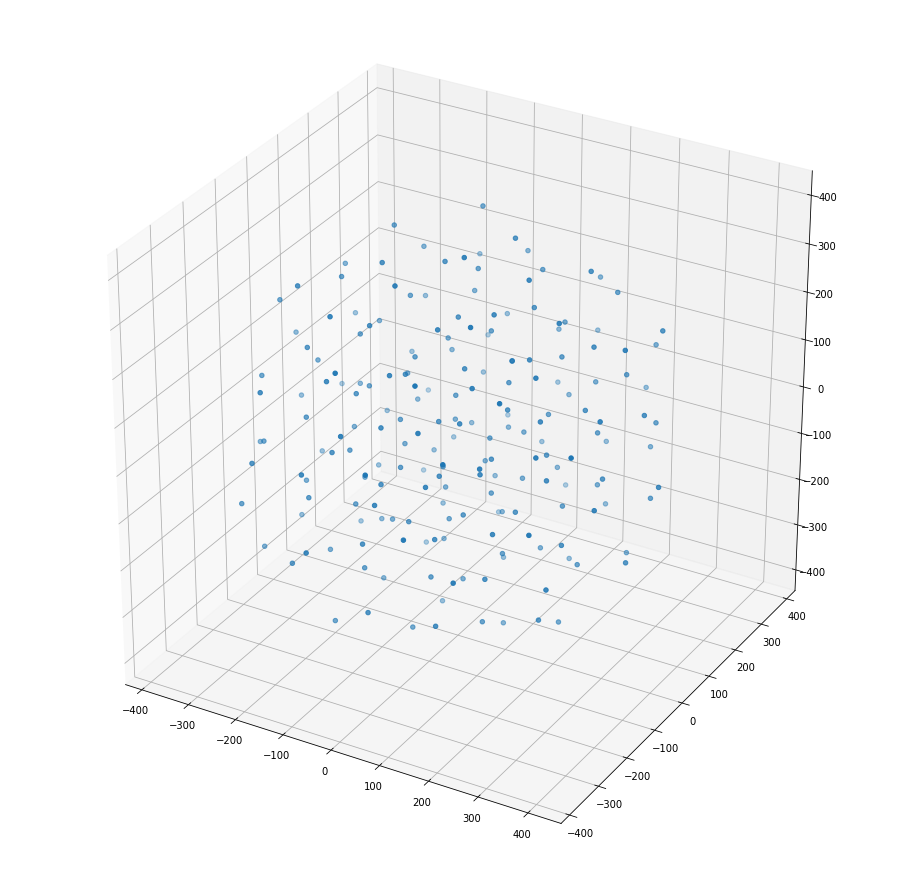

In [22]:
plot_3d(X, w, h, d)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


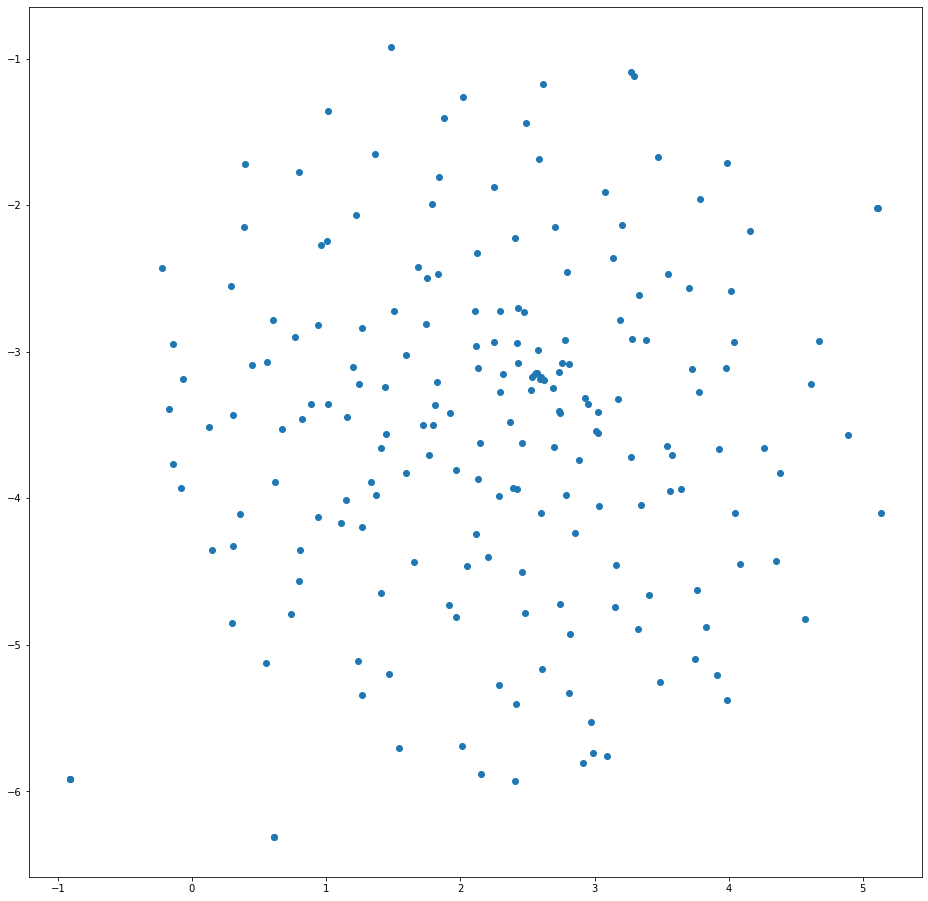

In [23]:
plot_2d(X, w, h, d)